# AutoRec for Cognitive Classification enhanced by First-order MAML

### by Xiaohuan Pei

## Data set

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy
%matplotlib inline
import progressbar
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

## show data set

In [19]:
def load_scores_data(file_path, ratio):
    student_index = 0
    score_matrix = []
    data = [] 
    f = open(file_path)
    for line in f.readlines():
        scores = line.split()
        scores = [int(i) for i in scores]
        score_matrix.append(scores)
        item_index = 0
        for score in scores:
            data.append([student_index, item_index, score])
            item_index += 1
        student_index += 1
    f.close()
    student_num = student_index
    item_num = item_index
    np.random.shuffle(data)
    train_data = data[ : int(len(data) * ratio)]
    test_data = data[int(len(data) * ratio) : ]
    return train_data, test_data 

In [20]:
train_data, _ = load_scores_data('./FrcSub/data.txt', 0.8)
df = pd.DataFrame(data=train_data, columns=['student id', 'item id', 'score'])
df.head()

,student id,item id,score
0,446,16,0
1,161,3,1
2,441,12,0
3,426,13,1
4,400,10,0


In [21]:
df.describe()

,student id,item id,score
count,8576.000000,8576.000000,8576.000000
mean,266.374883,9.513759,0.530784
std,155.128072,5.765104,0.499081
min,0.000000,0.000000,0.000000
25%,132.000000,5.000000,0.000000
50%,266.000000,10.000000,1.000000
75%,400.000000,15.000000,1.000000
max,535.000000,19.000000,1.000000


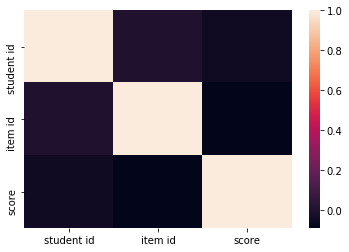

In [25]:
le = LabelEncoder()
datas = df.apply(le.fit_transform)
sns.heatmap(datas.corr())

## load data => shuffle, split, sample

In [27]:
def load_data(file_path, train_ratio):
    
    datas = []
    scores = pd.read_csv(file_path, header=None, sep='\t').values
    num_students, num_items, num_total_scores = scores.shape[0], scores.shape[1], scores.shape[0] * scores.shape[1]
    
    student_train_set = set()
    student_test_set = set()
    item_train_set = set()
    item_test_set = set()
    
    train_scores = np.zeros(scores.shape)
    test_scores = np.zeros(scores.shape)
    train_mask_scores = np.zeros(scores.shape)
    test_mask_scores = np.zeros(scores.shape)
    
    
    #先把认知诊断数据集转化成推荐系统中常用的三元组形式
    student_index = 0
    for line in scores:
        item_index = 0
        for score in line:
            datas.append([student_index, item_index, score.item()])
            item_index += 1
        student_index += 1
    
    #Shuffle data index
    #random_perm_index = np.arange(num_total_scores)
    random_perm_index = np.random.permutation(num_total_scores)
    train_index = random_perm_index[0 : int(num_total_scores * train_ratio)]
    test_index = random_perm_index[int(num_total_scores * train_ratio): ]
    
    #Train data (with valid data)
    for index in train_index:
        line = datas[index]
        student_index, item_index, score = line[0], line[1], line[2]
        train_scores[student_index, item_index] = score
        train_mask_scores[student_index, item_index] = 1
        student_train_set.add(student_index)
        item_train_set.add(item_index)
    
    #Test data
    for index in test_index:
        line = datas[index]
        student_index, item_index, score = line[0], line[1], line[2]
        test_scores[student_index, item_index] = score
        test_mask_scores[student_index, item_index] = 1
        student_test_set.add(student_index)
        item_test_set.add(item_index)
    
    return train_scores, test_scores, train_mask_scores, test_mask_scores,\
           student_train_set, item_train_set, student_test_set, item_test_set, \
           num_students, num_items, num_total_scores

    
def shuffle_data(x, x_mask, y):
    num_sample = len(x)
    indices = list(range(num_sample))
    random.shuffle(indices)
    return x[indices], x_mask[indices], y[indices]

def split_data(x, x_mask, y, ratio):
    x_train = x[ : int(len(x) * ratio)]
    x_train_mask = x_mask[ : int(len(x_mask) * ratio)]
    y_train = y[ : int(len(y) * ratio)]
    
    x_test = x[int(len(x) * ratio) : ]
    x_test_mask = x_mask[int(len(x_mask) * ratio) : ]
    y_test = y[int(len(y) * ratio) : ]
    
    return x_train, x_train_mask, y_train, x_test, x_test_mask, y_test

def sample_data(x, x_mask, y, k):
    x, x_mask, y = shuffle_data(x, x_mask, y)
    x_sample = x[ : k]
    x_sample_mask = x_mask[ : k]
    y_sample = y[ : k]
    return x_sample, x_sample_mask, y_sample

In [52]:
train_scores, test_scores, train_mask_scores, test_mask_scores,\
student_train_set, item_train_set, student_test_set, item_test_set, \
num_students, num_items, num_total_scores = load_data('./FrcSub/data.txt', 0.01)

In [30]:
def print_P_N():
    count1, count2, count3, count4 = 0, 0, 0, 0
    for student in range(num_students):
        for item in range(num_items):
            if train_mask_scores[student, item].item() == 1 and train_scores[student, item].item() > 0.5:
                count1 += 1
            if train_mask_scores[student, item].item() == 1 and train_scores[student, item].item()<= 0.5:  
                count2 += 1
            if test_mask_scores[student, item].item() == 1 and test_scores[student, item].item() > 0.5:
                count3 += 1
            if test_mask_scores[student, item].item() == 1 and test_scores[student, item].item() <= 0.5:
                count4 += 1
    print("Positive in train: {:4.0f} | Negtive in train: {:4.0f} | Positive in test: {:4.0f} | Negtive in test: {:4.0f}".format(count1, count2, count3, count4))
    print("Total rating numbers:", count1 + count2 + count3 + count4)
def detect_have_test_data(x_mask_batch):
    for student in range(x_mask_batch.shape[0]):
        for item in range(x_mask_batch.shape[1]):
            if x_mask_batch[student, item].item() == 1 and test_mask_scores[student, item].item() == 1: #train和test mask不能同时为1
                print("Error!")
                return True
    return False
#flag = detect_have_test_data(train_mask_scores)
#print_P_N()
#print(num_students * num_items)

## AutoEncoder
encode item to anilities or knowledge statement\
decode them back to corresponding item for recommendation

In [63]:
#item-based-AutoRec
class AutoRec(nn.Module):
    
    def __init__(self, num_students, num_items):
        super(AutoRec, self).__init__()
        #self.args = args
        self.num_students = num_students
        self.num_items = num_items
        self.hidden_units = 500
        self.encoder = nn.Sequential(
            nn.Linear(self.num_items, self.hidden_units),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.hidden_units, self.num_items),
        )
        
    def forward(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded  

## meta-learning
Let $\theta$ be the parameters that represent weights of encoder and decoder.
Given a task $\tau_i$ based on dataset $\mathcal{D}_{train}, \mathcal{D}_{test}$, we can update the parameters of encoder and decoder:
\begin{gather}
    \theta^t_i \gets \theta - \bigtriangledown_{\theta}Loss_{\tau_i}(E(D(r^i))_{\theta})
\end{gather}
where $\alpha$ is learning rate of each task and the $Loss$ denotes the loss computed using the mini data batch of each task.
To achieve promising generalization across a variety of tasks, our goal is to find optimal $\theta_i$:
\begin{gather}
    \theta_i \gets \mathop{\arg\min}_{\theta} \sum Loss_{\tau_i}(E(D(r^i))_{{\theta}^t_i})
\end{gather}

### here we choose the First-Order MAML, the algorithm is following:

![](image1.png)

In [82]:
class MAML(object):
    def __init__(self, x, x_mask, y, model, optimizer):
        
        self.x_ = x
        self.x_mask_ = x_mask
        self.y_ = y
        self.model_ = model
        self.optimizer_ = optimizer
        self.num_tasks = 20
        self.num_samples = 20
        self.task_epochs = 100
        self.alpha = 1e-5
        self.beta = 1e-5
        self.lam = 1e-3
        self.train_epochs = 100
        self.batch_size = 100
        
        #绘制图像所需参数
        self.trainLoss_ = []
        self.trainRmse_ = []
       
    def train_task(self, x_task, x_task_mask, y_task):
        decoded = self.model_(x_task)
        loss, _ = self.get_loss_rmse(decoded, x_task, x_task_mask)
        #loss = ((decoded - x_task) * x_task_mask).pow(2).sum()
        self.model_.zero_grad()
        loss.backward()
        self.optimizer_.step()
        
    def learn_algorithm(self):
        
        print("Learning an algorithm by meta-learning....")
        
        
        #task_loader = Data.DataLoader(dataset=train_dataset, batch_size=self.num_tasks, shuffle=True)
        
        for e in range(self.task_epochs):        
            
            self.opti_params_ = []

            #for train task i in batch of tasks
            for i in range(self.num_tasks):
                
                
                x_task, x_task_mask, y_task = \
                sample_data(self.x_, self.x_mask_, self.y_, 
                            self.num_samples)
                
                x_task, x_task_mask, y_task = \
                torch.tensor(x_task).type(torch.FloatTensor), \
                torch.tensor(x_task_mask).type(torch.FloatTensor), \
                torch.tensor(y_task).type(torch.FloatTensor)
    
                self.train_task(x_task, x_task_mask, y_task)
                
                opti_params = deepcopy(self.model_.state_dict())
                
                self.opti_params_.append(opti_params)
            
                
            meta_grad_dict = deepcopy(self.model_.state_dict())
            meta_grad_dict = {name: nn.init.constant_(\
            meta_grad_dict[name], 0.) for name in meta_grad_dict} 
            
            
            
            for i in range(self.num_tasks):
                
                
                x_task, x_task_mask, y_task = \
                sample_data(self.x_, self.x_mask_, self.y_, self.num_samples)
                
                
                x_task, x_task_mask, y_task = \
                torch.tensor(x_task).type(torch.FloatTensor), \
                torch.tensor(x_task_mask).type(torch.FloatTensor), \
                torch.tensor(y_task).type(torch.FloatTensor)
    
                net_optim = AutoRec(num_students, num_items)
                
                net_optim.load_state_dict(self.opti_params_[i])
                
                decoded = net_optim(x_task)
                
                loss, _ = self.get_loss_rmse(decoded, x_task, x_task_mask)
                
                #loss = ((decoded - x_task) * x_task_mask).pow(2).sum()
                
                loss.backward()

                
                #update meta gradient bt net_optim_params's grad
                net_optim_params_grad = {}
                for name, params in zip(net_optim.state_dict(), 
                                        net_optim.parameters()):
                    net_optim_params_grad[name] = params.grad.data
                #print(net_optim_params_grad)
                meta_grad_dict = {name: meta_grad_dict[name] + 
                                  net_optim_params_grad[name] / 
                                  self.num_samples for name in meta_grad_dict} 
                
                #state_dict() has no grad
                #meta_grad_dict = {name: meta_grad_dict[name] + net_optim_params[name].grad.data / self.num_samples for name in meta_grad_dict} 
            
            
            #update net params by meta gradient
            net_params = self.model_.state_dict()
            net_params_new = {name: net_params[name] + 
                              self.beta * meta_grad_dict[name] / 
                              self.num_samples for name in net_params} 
            self.model_.load_state_dict(net_params_new)
          
        
    def get_loss_rmse(self, decoded, x_batch, x_batch_mask):
        
        loss_basic = 0
        loss_regular = 0
        
        #basic loss
        loss_basic += ((decoded - x_batch) * x_batch_mask).pow(2).sum()
        rmse = loss_basic
        
        
        #regular loss
        for dict_params in self.optimizer_.param_groups:
            for params in dict_params['params']:
                # print(type(j.data), j.shape,j.data.dim())
                # W.l2_normal, V.l2_normal
                if params.data.dim() == 2:
                    loss_regular += torch.t(params.data).pow(2).sum()
        
        #total loss
        loss = loss_basic + loss_regular * self.lam * 0.5
        return loss, rmse
    
    def get_test_error(self, decoded, x_batch, x_batch_mask):
        return ((decoded - x_batch) * x_batch_mask).pow(2).sum()
    
    def train_batch(self):
        Rmse = 0
        Loss = 0
        for step, (x_batch, x_batch_mask, y_batch) in enumerate(train_loader):
            
            x_batch = x_batch.type(torch.FloatTensor)#.cuda()
            x_batch_mask = x_batch_mask.type(torch.FloatTensor)#.cuda()
            
            decoded = self.model_(x_batch) #x_batch.shape = [100, 20] = decoded
            loss, rmse = self.get_loss_rmse(decoded=decoded, x_batch=x_batch, x_batch_mask=x_batch_mask)
            self.optimizer_.zero_grad()
            loss.backward()
            self.optimizer_.step()
            Loss += loss
            Rmse += rmse

        Rmse = np.sqrt(Rmse.detach().cpu().numpy() / (train_mask_scores == 1).sum())
        
        self.trainLoss_.append(Loss)
        self.trainRmse_.append(Rmse)

        #print('epoch ', epoch,  '| train Rmse : ', Rmse)
    
    def train(self):
        bar = progressbar.ProgressBar()
        for epoch in bar(range(self.train_epochs)):
            self.train_batch()
            
    def predict(self):
        test_scores_ = torch.from_numpy(test_scores).type(torch.FloatTensor)#.cuda()
        test_mask_scores_ = torch.from_numpy(test_mask_scores).type(torch.FloatTensor)#.cuda()
        
        scores_predict = self.model_(test_scores_)
        error = self.get_test_error(scores_predict, test_scores_, test_mask_scores_)
        error = np.sqrt(error.detach().cpu().numpy() / (test_mask_scores == 1).sum())
        return error

    def draw_train_loss(self):
        fig, ax = plt.subplots()
        ax.set_title("Train Loss")
        ax.plot(self.trainLoss_, label='Train Loss')
        ax.legend()
        
    def draw_train_rmse(self):
        fig, ax = plt.subplots()
        ax.set_title("Train Rmse")
        ax.plot(self.trainRmse_, label='Train Rmse')
        ax.legend()
        
    def classify(self, pred_value):
        if pred_value <= 0.5:
            pred_value = 0
        else:
            pred_value = 1
        return pred_value
    

    
    def get_scores(self, test_scores, test_mask_scores):
        
        test_scores_ = torch.from_numpy(test_scores).type(torch.FloatTensor)#.cuda()
        predict_scores_ = self.model_(test_scores_).detach().numpy()
        
        
        pred_scores = predict_scores_[test_mask_scores == 1]
        true_scores = test_scores_[test_mask_scores == 1]
        

        
        true_scores[true_scores > 0.5] = 1
        true_scores[true_scores <= 0.5] = 0
        
        fpr, tpr, thresholds = metrics.roc_curve(true_scores, pred_scores)
        
        pred_scores[pred_scores > 0.5] = 1
        pred_scores[pred_scores <= 0.5] = 0

        accuracy = accuracy_score(true_scores, pred_scores)
        precision = precision_score(true_scores, pred_scores)
        recall = recall_score(true_scores, pred_scores)
        f1 = f1_score(true_scores, pred_scores)
        roc_auc = roc_auc_score(true_scores, pred_scores)
        
        return accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc
    
    def show_roc_curve(self, fpr, tpr):
        plt.figure()
        lw = 2
        plt.plot(fpr[2], tpr[2], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([-0.01, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

In [67]:
def show_roc_curve(fpr_, tpr_, roc_auc_):
    fig, ax = plt.subplots()
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(fpr_[0], tpr_[0], alpha=0.7, color='darkorange', lw=2, label='ROC curve Auto(area = %0.3f)' % roc_auc_[0])
    ax.plot(fpr_[1], tpr_[1], alpha=0.7, color='r', lw=2, label='ROC curve meta-Auto(area = %0.3f)' % roc_auc_[1])
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([-0.01, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

In [68]:
def show_rmse(rmse_):
    fig, ax = plt.subplots()
    ax.set_title('Root Mean Square Error')
    ax.plot(rmse_[0], alpha=0.7, color='darkorange', lw=2, label='Train by Auto(start rmse = %0.3f)' % rmse_[0][0])
    ax.plot(rmse_[1], alpha=0.7, color='r', lw=2, label='Train by meta-Auto(start rmse = %0.3f)' % rmse_[1][0])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Rmse')
    ax.legend()

In [75]:
batch_size = 100
model1 = AutoRec(num_students, num_items)
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 1e-3, weight_decay=1e-5)

model2 = deepcopy(model1)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 1e-4, weight_decay=1e-6)

num_batch = int(math.ceil(num_students / batch_size))
train_dataset = Data.TensorDataset(torch.from_numpy(train_scores),torch.from_numpy(train_mask_scores),torch.from_numpy(train_scores))
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [76]:
meta1 = MAML(train_scores, train_mask_scores, train_scores, model1, optimizer1)
meta2 = MAML(train_scores, train_mask_scores, train_scores, model2, optimizer2)

Recommendation model scores before training: 
------------------------Autoencoder-----------------------------
Accuracy: 0.460756 | precision: 0.393443 | recall: 0.016928 | F1: 0.032460 | ROC_AUC_score: 0.493490
----------------------meta-Autoencoder--------------------------
Accuracy: 0.460756 | precision: 0.393443 | recall: 0.016928 | F1: 0.032460 | ROC_AUC_score: 0.493490


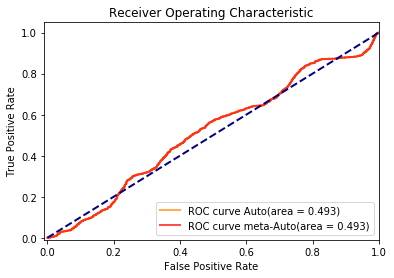

In [77]:
#未训练之前
tpr_, fpr_, roc_auc_ = [], [], []
accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = meta1.get_scores(test_scores, test_mask_scores)
tpr_.append(tpr)
fpr_.append(fpr)
roc_auc_.append(roc_auc)
print("Recommendation model scores before training: ")
print("------------------------Autoencoder-----------------------------")
print("Accuracy: {:4.6f} | precision: {:4.6f} | recall: {:4.6f} | F1: {:4.6f} | ROC_AUC_score: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))

accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = meta2.get_scores(test_scores, test_mask_scores)
tpr_.append(tpr)
fpr_.append(fpr)
roc_auc_.append(roc_auc)
print("----------------------meta-Autoencoder--------------------------")
print("Accuracy: {:4.6f} | precision: {:4.6f} | recall: {:4.6f} | F1: {:4.6f} | ROC_AUC_score: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))

show_roc_curve(fpr_, tpr_, roc_auc_)

In [78]:
meta1.train()

100% |########################################################################|


In [79]:
meta2.train_epochs=1000
meta2.learn_algorithm()
meta2.train()

Learning an algorithm by meta-learning....


100% |########################################################################|


Recommendation model scores after training: 
------------------------Autoencoder-----------------------------
Accuracy: 0.874117 | precision: 0.915628 | recall: 0.842003 | F1: 0.877274 | ROC_AUC_score: 0.876485
----------------------meta-Autoencoder--------------------------
Accuracy: 0.893715 | precision: 0.927215 | recall: 0.869335 | F1: 0.897343 | ROC_AUC_score: 0.895513


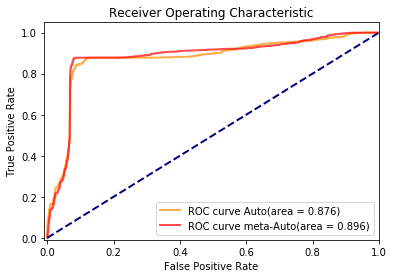

In [80]:
tpr_, fpr_, roc_auc_ = [], [], []
accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = meta1.get_scores(test_scores, test_mask_scores)
tpr_.append(tpr)
fpr_.append(fpr)
roc_auc_.append(roc_auc)
print("Recommendation model scores after training: ")
print("------------------------Autoencoder-----------------------------")
print("Accuracy: {:4.6f} | precision: {:4.6f} | recall: {:4.6f} | F1: {:4.6f} | ROC_AUC_score: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))

accuracy, precision, recall, f1, fpr, tpr, thresholds, roc_auc = meta2.get_scores(test_scores, test_mask_scores)
tpr_.append(tpr)
fpr_.append(fpr)
roc_auc_.append(roc_auc)
print("----------------------meta-Autoencoder--------------------------")
print("Accuracy: {:4.6f} | precision: {:4.6f} | recall: {:4.6f} | F1: {:4.6f} | ROC_AUC_score: {:4.6f}".format(accuracy, precision, recall, f1, roc_auc))

show_roc_curve(fpr_, tpr_, roc_auc_)

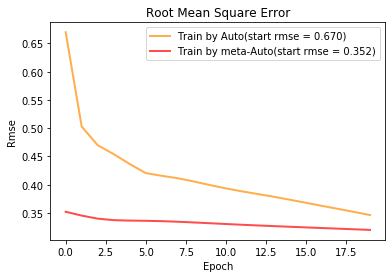

In [81]:
rmse_ = []
rmse_.append(meta1.trainRmse_[:20])
rmse_.append(meta2.trainRmse_[:20])
show_rmse(rmse_)

# From the demo we can see:

## With the meta-learning (red line) enhancement, the error Rsme is already very small at the initial stage of training which means it started faster.

## If training multiple times with enough data, the final prediction results (ROC red orange curve) of the two methods are very close.